In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
import requests_cache

session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',     'Accept': 'application/json;charset=utf-8'}


df=web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-11-10', session=session)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591938
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659609
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800156
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933965
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913450
...,...,...,...,...,...,...
2021-11-04,152.429993,150.639999,151.580002,150.960007,60394600.0,150.740005
2021-11-05,152.199997,150.059998,151.889999,151.279999,65414600.0,151.279999
2021-11-08,151.570007,150.160004,151.410004,150.440002,55020900.0,150.440002


In [3]:
df.reset_index('Date', inplace=True)

In [4]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591938
1,2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659609
2,2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800156
3,2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933965
4,2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913450
...,...,...,...,...,...,...,...
2477,2021-11-04,152.429993,150.639999,151.580002,150.960007,60394600.0,150.740005
2478,2021-11-05,152.199997,150.059998,151.889999,151.279999,65414600.0,151.279999
2479,2021-11-08,151.570007,150.160004,151.410004,150.440002,55020900.0,150.440002
2480,2021-11-09,151.429993,150.059998,150.199997,150.809998,56787900.0,150.809998


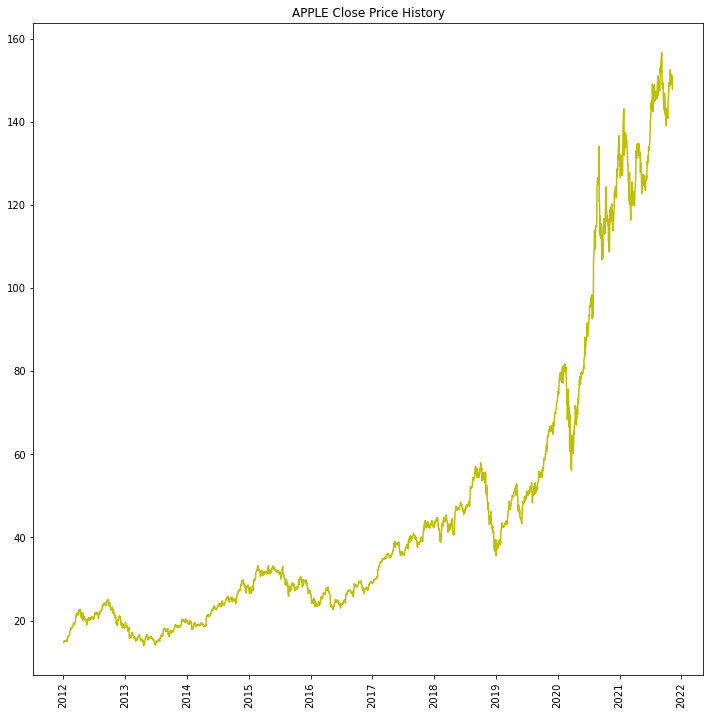

In [5]:
#visualize the closing price history:
plt.figure(figsize=(12,12))
plt.title('APPLE Close Price History')
plt.plot(df['Date'], df['Close'], color='y')
plt.xticks(rotation=90)
plt.show()

In [6]:
data=df[['Close']]
dataset=np.array(data)
type(dataset)
training_data_len= math.ceil(len(dataset) * .8)

print(training_data_len)

1986


In [7]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)
scaled_data

array([[0.00517915],
       [0.00573209],
       [0.00688052],
       ...,
       [0.95621486],
       [0.95880691],
       [0.93856067]])

In [8]:
print('dataset==>\n', dataset)
print('\n')
print('df[[\'Close\']]==>')
df[['Close']]

dataset==>
 [[ 14.6867857 ]
 [ 14.76571369]
 [ 14.92964268]
 ...
 [150.44000244]
 [150.80999756]
 [147.91999817]]


df[['Close']]==>


,Close
0,14.686786
1,14.765714
2,14.929643
3,15.085714
4,15.061786
...,...
2477,150.960007
2478,151.279999
2479,150.440002
2480,150.809998


In [9]:
#Create the training dataset
#Create the scaled training 
train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train datasets
x_train=[]
y_train=[]

#we use last 60 days as the training set to predict the next day, and 61 day as the label
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])


In [10]:
#convert the x_train and y_train to numpy arrays
x_train, y_train= np.array(x_train), np.array(y_train)

In [11]:
#LSTM expects 3 dimentional dataset
x_train=np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))# rows, columns, 
x_train.shape

(1926, 60, 1)

In [12]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1926/1926 [==============================] - 30s 14ms/step - loss: 2.3721e-04


In [15]:
#create testing dataset
testing_data_len=len(dataset)-training_data_len
testing_data_len

496

In [16]:
#test_data = scaled_data[training_data_len-60: , :]
#len(test_data)
x_test=[]
y_test=dataset[training_data_len: , :]#using unscaled dataset
for i in range(training_data_len, len(scaled_data)):
    x_test.append(scaled_data[i-60: i, 0])




In [17]:
x_test=np.array(x_test)


In [18]:
x_test.shape

(496, 60)

In [19]:
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [20]:
#Get the mdoels predicted price values
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

In [21]:
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.094109873617849

In [22]:
len(scaled_data)-training_data_len

496

In [23]:
training_data_len

1986

In [24]:
predictions


array([[ 69.741486],
       [ 69.6821  ],
       [ 69.71261 ],
       [ 69.733055],
       [ 69.84484 ],
       [ 69.98019 ],
       [ 70.0343  ],
       [ 69.91356 ],
       [ 69.77119 ],
       [ 69.73221 ],
       [ 69.891716],
       [ 70.04347 ],
       [ 70.22206 ],
       [ 70.4589  ],
       [ 70.72244 ],
       [ 71.0744  ],
       [ 71.566284],
       [ 72.10052 ],
       [ 72.58771 ],
       [ 73.00793 ],
       [ 73.33211 ],
       [ 73.69361 ],
       [ 74.04394 ],
       [ 74.50701 ],
       [ 74.98105 ],
       [ 75.46238 ],
       [ 75.95737 ],
       [ 76.59275 ],
       [ 77.159805],
       [ 77.70043 ],
       [ 78.131935],
       [ 78.59213 ],
       [ 79.195595],
       [ 79.83481 ],
       [ 80.61411 ],
       [ 81.27211 ],
       [ 81.76431 ],
       [ 82.22266 ],
       [ 82.7089  ],
       [ 83.10048 ],
       [ 83.43438 ],
       [ 83.744576],
       [ 83.98479 ],
       [ 83.90538 ],
       [ 83.90589 ],
       [ 84.12687 ],
       [ 84.43311 ],
       [ 84.3

In [25]:
#Plot the data
train=df[['Date','Close']][:training_data_len]
valid=df[['Date','Close']][training_data_len:]
valid['Predictions']=predictions
valid

,Date,Close,Predictions
1986,2019-11-22,65.445000,69.741486
1987,2019-11-25,66.592499,69.682098
1988,2019-11-26,66.072502,69.712608
1989,2019-11-27,66.959999,69.733055
1990,2019-11-29,66.812500,69.844841
...,...,...,...
2477,2021-11-04,150.960007,158.301804
2478,2021-11-05,151.279999,158.498291
2479,2021-11-08,150.440002,158.705185
2480,2021-11-09,150.809998,158.796005


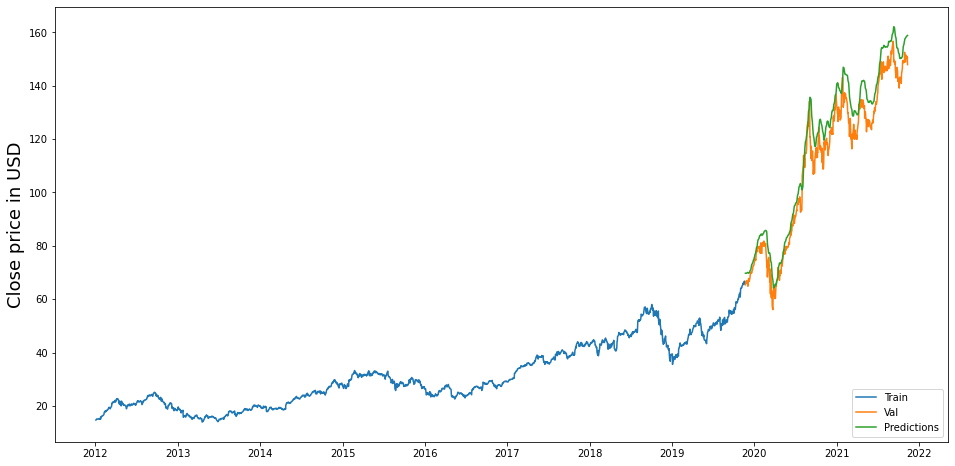

In [26]:
plt.figure(figsize=(16,8))
plt.ylabel('Close price in USD', fontsize=18)
plt.plot(train['Date'],train['Close'])
plt.plot(valid['Date'],valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
valid=df[['Date','Close']][training_data_len:]
    

In [29]:
valid=df[['Date','Close']][training_data_len:]
valid['Predictions']=predictions
valid

,Date,Close,Predictions
1986,2019-11-22,65.445000,69.741486
1987,2019-11-25,66.592499,69.682098
1988,2019-11-26,66.072502,69.712608
1989,2019-11-27,66.959999,69.733055
1990,2019-11-29,66.812500,69.844841
...,...,...,...
2477,2021-11-04,150.960007,158.301804
2478,2021-11-05,151.279999,158.498291
2479,2021-11-08,150.440002,158.705185
2480,2021-11-09,150.809998,158.796005


In [30]:
#Get the quote
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591938
1,2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659609
2,2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800156
3,2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933965
4,2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913450
...,...,...,...,...,...,...,...
2477,2021-11-04,152.429993,150.639999,151.580002,150.960007,60394600.0,150.740005
2478,2021-11-05,152.199997,150.059998,151.889999,151.279999,65414600.0,151.279999
2479,2021-11-08,151.570007,150.160004,151.410004,150.440002,55020900.0,150.440002
2480,2021-11-09,151.429993,150.059998,150.199997,150.809998,56787900.0,150.809998


In [31]:
new_df=df[['Date','Close']]
new_df

,Date,Close
0,2012-01-03,14.686786
1,2012-01-04,14.765714
2,2012-01-05,14.929643
3,2012-01-06,15.085714
4,2012-01-09,15.061786
...,...,...
2477,2021-11-04,150.960007
2478,2021-11-05,151.279999
2479,2021-11-08,150.440002
2480,2021-11-09,150.809998


In [35]:
#Get the last 60 days closing values and convert the dataframe to an array
last_60_days=np.array(new_df[-60:][['Close']])
last_60_days

array([[146.36000061],
       [146.69999695],
       [148.19000244],
       [149.71000671],
       [149.61999512],
       [148.36000061],
       [147.53999329],
       [148.6000061 ],
       [153.11999512],
       [151.83000183],
       [152.50999451],
       [153.6499939 ],
       [154.30000305],
       [156.69000244],
       [155.11000061],
       [154.07000732],
       [148.97000122],
       [149.55000305],
       [148.11999512],
       [149.02999878],
       [148.78999329],
       [146.05999756],
       [142.94000244],
       [143.42999268],
       [145.8500061 ],
       [146.83000183],
       [146.91999817],
       [145.36999512],
       [141.91000366],
       [142.83000183],
       [141.5       ],
       [142.6499939 ],
       [139.13999939],
       [141.11000061],
       [142.        ],
       [143.28999329],
       [142.8999939 ],
       [142.80999756],
       [141.50999451],
       [140.91000366],
       [143.75999451],
       [144.83999634],
       [146.55000305],
       [148

In [37]:
last_60_days_scaled=scaler.transform(last_60_days)
last_60_days_scaled

array([[0.92763191],
       [0.9300138 ],
       [0.94045221],
       [0.95110079],
       [0.9504702 ],
       [0.94164316],
       [0.9358985 ],
       [0.94332454],
       [0.97498988],
       [0.96595267],
       [0.97071644],
       [0.97870285],
       [0.98325657],
       [1.        ],
       [0.9889311 ],
       [0.9816453 ],
       [0.94591659],
       [0.94997986],
       [0.93996177],
       [0.94633691],
       [0.94465552],
       [0.9255302 ],
       [0.9036727 ],
       [0.90710539],
       [0.92405908],
       [0.93092456],
       [0.93155504],
       [0.92069631],
       [0.89645692],
       [0.90290208],
       [0.89358459],
       [0.90164101],
       [0.87705131],
       [0.8908524 ],
       [0.8970874 ],
       [0.9061246 ],
       [0.90339241],
       [0.90276193],
       [0.8936546 ],
       [0.88945129],
       [0.90941725],
       [0.91698334],
       [0.928963  ],
       [0.94444536],
       [0.94794817],
       [0.94948942],
       [0.94395502],
       [0.943

In [38]:
X_test=[]
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test to a numpy array
X_test=np.array(X_test)
#Resahpe
X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(1, 60, 1)

In [40]:
pred_price=model.predict(X_test)
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)

[[158.57474]]


In [47]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',     'Accept': 'application/json;charset=utf-8'}


apple_current=web.DataReader('AAPL', data_source='yahoo', start='2021-11-11', end='2021-11-11', session=session)
apple_current.reset_index(inplace=True)
print(apple_current[['Date','Close']])

        Date       Close
0 2021-11-10  147.919998
1 2021-11-11  147.869995
